In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
import openslide
from openslide import OpenSlide
import cv2 

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

In [3]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [5]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)

In [6]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


The size of the image is(8267, 10533, 3)


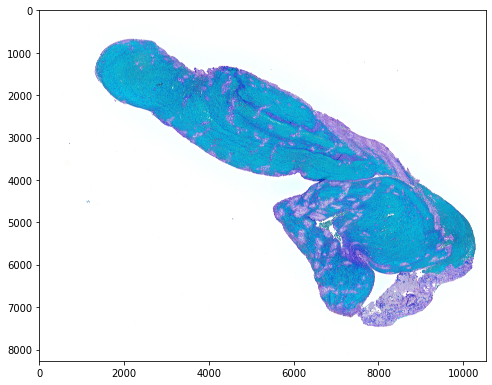

CPU times: user 8.92 s, sys: 1.85 s, total: 10.8 s
Wall time: 11 s


In [7]:
%%time
import cv2
from PIL import Image
import tifffile as tifi
j = 4
sample_train = train_df[j:j+1]

img = cv2.imread(sample_train.loc[j, "file_path"])
print('The size of the image is' + str(img.shape))
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()  

2022-09-07 01:15:05.550571: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The size of the image is(512, 512, 3)


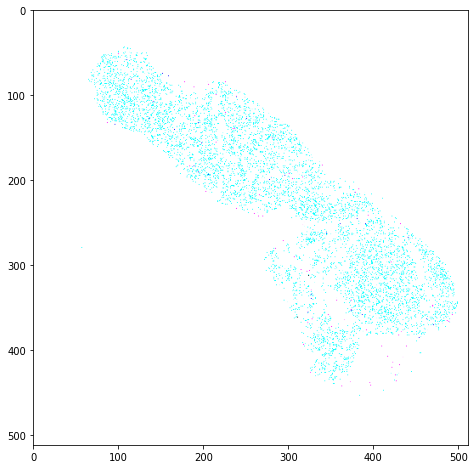

In [8]:
image_resized = tf.image.resize(img, (512, 512),method=tf.image.ResizeMethod.LANCZOS5)
print('The size of the image is' + str(image_resized.shape))
plt.figure(figsize=(8, 8))
plt.imshow(image_resized)
plt.show()  

CPU times: user 7.87 s, sys: 2.47 s, total: 10.3 s
Wall time: 25.5 s


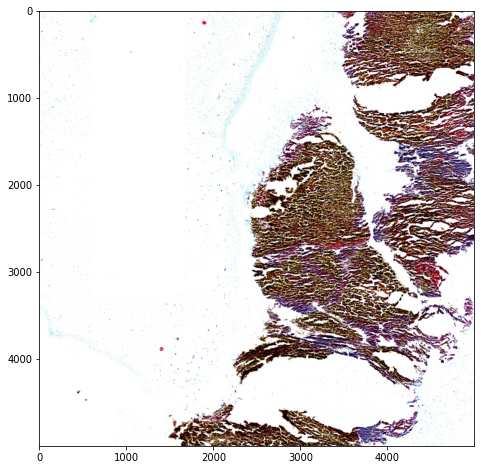

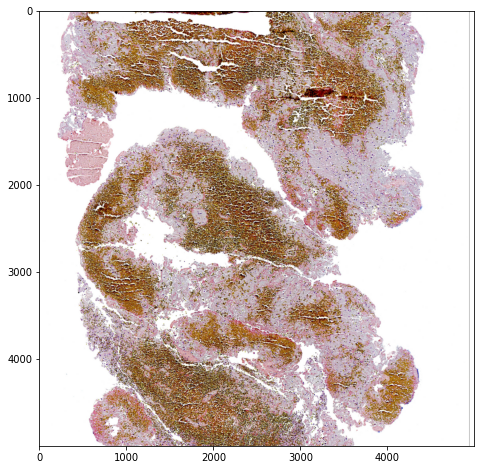

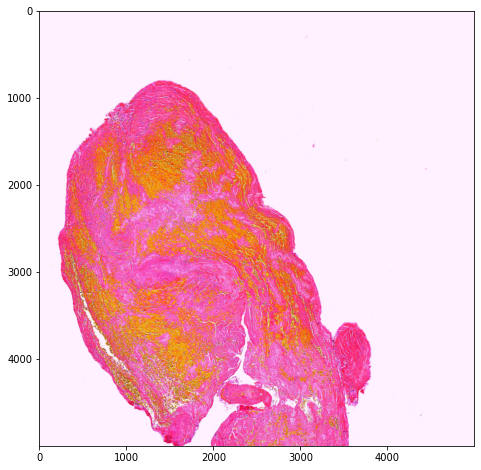

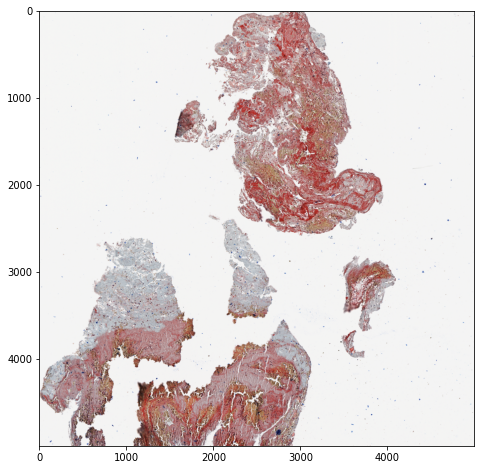

In [9]:
%%time
sample_train = train_df[:4]

for i in range(4):
    slide = OpenSlide(sample_train.loc[i, "file_path"])
    region = (1000, 1000)
    size = (5000, 5000)
    region = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(region)

In [10]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (1000,1000)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    #print('imgae shape is' + str(image.size))
    image = tf.image.resize(image, (380, 380),method=tf.image.ResizeMethod.LANCZOS5)
    image = np.array(image) / 255.0 # Normalization
    return image

x_train=[]
# num_img = 100
# counter = 0
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    #print(x1.shape)
    x_train.append(x1[:,:,0:3]) # Channel four is useless
#     counter += 1
#     if (counter == num_img):
#         break
    

100%|██████████| 754/754 [52:55<00:00,  4.21s/it]

CPU times: user 18min 43s, sys: 7min 10s, total: 25min 54s
Wall time: 52min 55s


In [11]:
import urllib.request
from tensorflow.keras.applications.efficientnet import EfficientNetB4

# Instantiate the model
pre_trained_model = EfficientNetB4(input_shape=(380, 380, 3),
                                include_top=False,
                                weights='imagenet')

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()


71696384/71686520 [==============================] - 0s 0us/step


In [12]:
from tensorflow.keras import Model

x = tf.keras.layers.GlobalAveragePooling2D()(pre_trained_model.output)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1)(x)

model = Model(pre_trained_model.input, x)

In [13]:
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),    
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.BinaryAccuracy(name="accuracy")],
    optimizer = tf.keras.optimizers.Adam(1e-3))

In [14]:
x_train=np.array(x_train)
#y_train=train_df['target'][0:num_img]
y_train=train_df['target']

x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2)

In [15]:
%%time

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint

# def step_decay(epoch):
#     initial_lrate = 0.001
#     drop = 0.5
#     epochs_drop = 20.0
#     lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
#     return lrate

# lrate = LearningRateScheduler(step_decay)
earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
lrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 20,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00000001,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/EN_model.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    epochs = 150,
    batch_size=32,
    validation_data = (x_test,y_test),
    verbose = 1,
    callbacks = [lrate, model_checkpoint_callback]
)

2022-09-07 02:08:52.737794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
19/19 [==============================] - 155s 7s/step - loss: 0.3597 - rmse: 0.5997 - accuracy: 0.5871 - val_loss: 0.3043 - val_rmse: 0.5516 - val_accuracy: 0.3113
Epoch 2/150
19/19 [==============================] - 129s 7s/step - loss: 0.3110 - rmse: 0.5576 - accuracy: 0.5572 - val_loss: 0.2897 - val_rmse: 0.5382 - val_accuracy: 0.3113
Epoch 3/150
19/19 [==============================] - 128s 7s/step - loss: 0.2911 - rmse: 0.5395 - accuracy: 0.5970 - val_loss: 0.3080 - val_rmse: 0.5550 - val_accuracy: 0.3113
Epoch 4/150
19/19 [==============================] - 128s 7s/step - loss: 0.2807 - rmse: 0.5298 - accuracy: 0.5755 - val_loss: 0.2939 - val_rmse: 0.5421 - val_accuracy: 0.3113
Epoch 5/150
19/19 [==============================] - 134s 7s/step - loss: 0.2709 - rmse: 0.5205 - accuracy: 0.6053 - val_loss: 0.3190 - val_rmse: 0.5648 - val_accuracy: 0.3113
Epoch 6/150
19/19 [==============================] - 128s 7s/step - loss: 0.2718 - rmse: 0.5214 - accuracy: 0.5854 - val

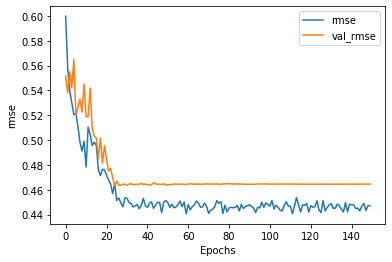

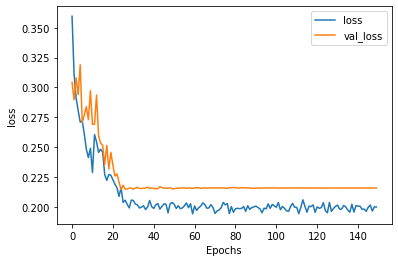

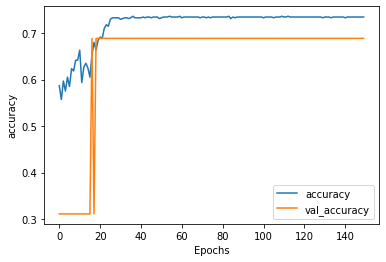

In [16]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.savefig(str(metric) +'.png')
    plt.show()
    
plot_graphs(history, "rmse")
#plt.savefig('accuracy.png')
plot_graphs(history, "loss")
#plt.savefig('loss.png')
plot_graphs(history, "accuracy")

In [17]:
#model.summary()

In [18]:
#del train_df, x_train
gc.collect()

12224

In [19]:
model = tf.keras.models.load_model('/kaggle/working/EN_model.h5')

In [20]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1[:,:,0:3])
test1=np.array(test1)

cnn_pred=model.predict(test1)

In [21]:
cnn_pred

array([[0.66229725],
       [0.66228294],
       [0.6622806 ],
       [0.6622824 ]], dtype=float32)

In [22]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["CE"] = sub["CE"].apply(lambda x : 0 if x<0 else x)
sub["CE"] = sub["CE"].apply(lambda x : 1 if x>1 else x)
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.662297,0.337703
1,008e5c,0.662283,0.337717
2,00c058,0.662281,0.337719
3,01adc5,0.662282,0.337718


In [23]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.662297,0.337703
008e5c,0.662283,0.337717
00c058,0.662281,0.337719
01adc5,0.662282,0.337718
